In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(5)

%run "./Aerospace-Project/DiffusionLunarKF.ipynb"

**Constants used in Covariance Matricies**

In [4]:
# variables
T_c = 0.00000009775
f_L1 = 1575420000
N_i = 4
CN0 = 15
B_pll = 0.5
B_fe = 26000000
T = 0.020
d = 0.3
pi = math.pi
c = 299792458
B_dll = 0.5
delta_t = 60
sigma_uere = 0 # can't find a value for this

**Time Transfer Process Covariance (Q)**

The values for h_0, h_m1, and h_m2 were found from DOI - 10.1007/s10291-015-0480-2 in Table 2

These were quite literally the only sources I was able to find on these values.

In [5]:
h_0 = 1.4*(10**(-22))
h_m1 = 2.3*(10**(-26))
h_m2 = 3.3*(10**(-31))

dt = 60

pi = math.pi

e1 = (h_0/2)*dt + 2*h_m1*(dt*dt) + (2/3)*((pi*h_m2*dt)**2)*dt
e2 = h_m1*dt + h_m2*(pi*dt)**2
e3 = (h_0/(2*dt))+ 4*h_m1 + (8/3)*(pi*pi)*h_m2*dt

Q = c*c*np.array([[e1,e2],[e2,e3]])

if __name__ == '__main__':
    print(Q)

[[3.92360561e-04 1.25082013e-07]
 [1.25082013e-07 1.13170154e-07]]


**Time Transfer GPS Measurement Covariance (R)**

Constants were given throughout time transfer paper, however resulting values seem off. Mainly, the psuedorange-rate residual's have a covariance on the order of 10^9. As such we sometimes opt to use R = I

Note: The size of R changes depending on how many satellites are visible to the station, as such we define R as a funcrion of the number of visible satellites (N).

In [6]:
s_dll = (B_dll/(2*CN0))*(1/(T_c*B_fe))*(1+(1/(T*CN0)))
pr_var = ((c*T_c)**2)*s_dll+ sigma_uere

s_pll = (B_pll/(CN0))*(1+(1/(2*T*CN0)))
prr_var = ((c**2)/((2*pi*f_L1 * T)**2)) * (s_pll)


R = lambda N :np.block([[pr_var*np.eye(N,N),np.zeros((N,N))],[np.zeros((N,N)),prr_var*np.eye(N,N)]])
# R = lambda N :9*np.eye(2*N,2*N)

In [7]:
H_cf = np.array([[1, 0], [1, 0], [0, 1], [0, 1]])
H_20x10 = np.zeros((20, 10))
for k in range(0, 20, 4):
    H_20x10[k:k+4, k//2:k//2+2] = H_cf

R_20x20 = np.zeros((20, 20))
for i in range(0, 10):
    R_20x20[i,i] = R(2)[0][0]
for i in range(10,20):
    R_20x20[i,i] = R(2)[1][1]


measure_noise = lambda : np.linalg.cholesky(R_20x20) @ np.random.normal(np.array([[0 for _ in range(20)]]).T)


In [8]:
sigma_j = 10**(-11)
#paper varies from s_j = 10^{-14} to 10^{-6}

In [9]:
# computing the MSE as a metric
def compute_mse(predictions, truth, n):
  mse = np.zeros((2,)) # array to store the MSE for bias and drift
  for i in range(n):
    mse[0] += np.mean((predictions[:, i, 0] - truth[:, i, 0])**2) # compute mse for bias
    mse[1] += np.mean((predictions[:, i, 1] - truth[:, n + i])**2) # compute mse for drift

  # normalize and return the mse value
  mse /= n
  return mse

**Filter Simulation**

Since the Coavariances are set above, we simply specify the diffusion weight matrix and the broadcast time matrix as well as the initial estimates and covariances for each station. Here is also where we create and update(with process noise) our true values for time, bias, and drift.

Right now we assume the weights are divided equally and our network topology is 5 nodes aranged in a plus with node 0 being the center

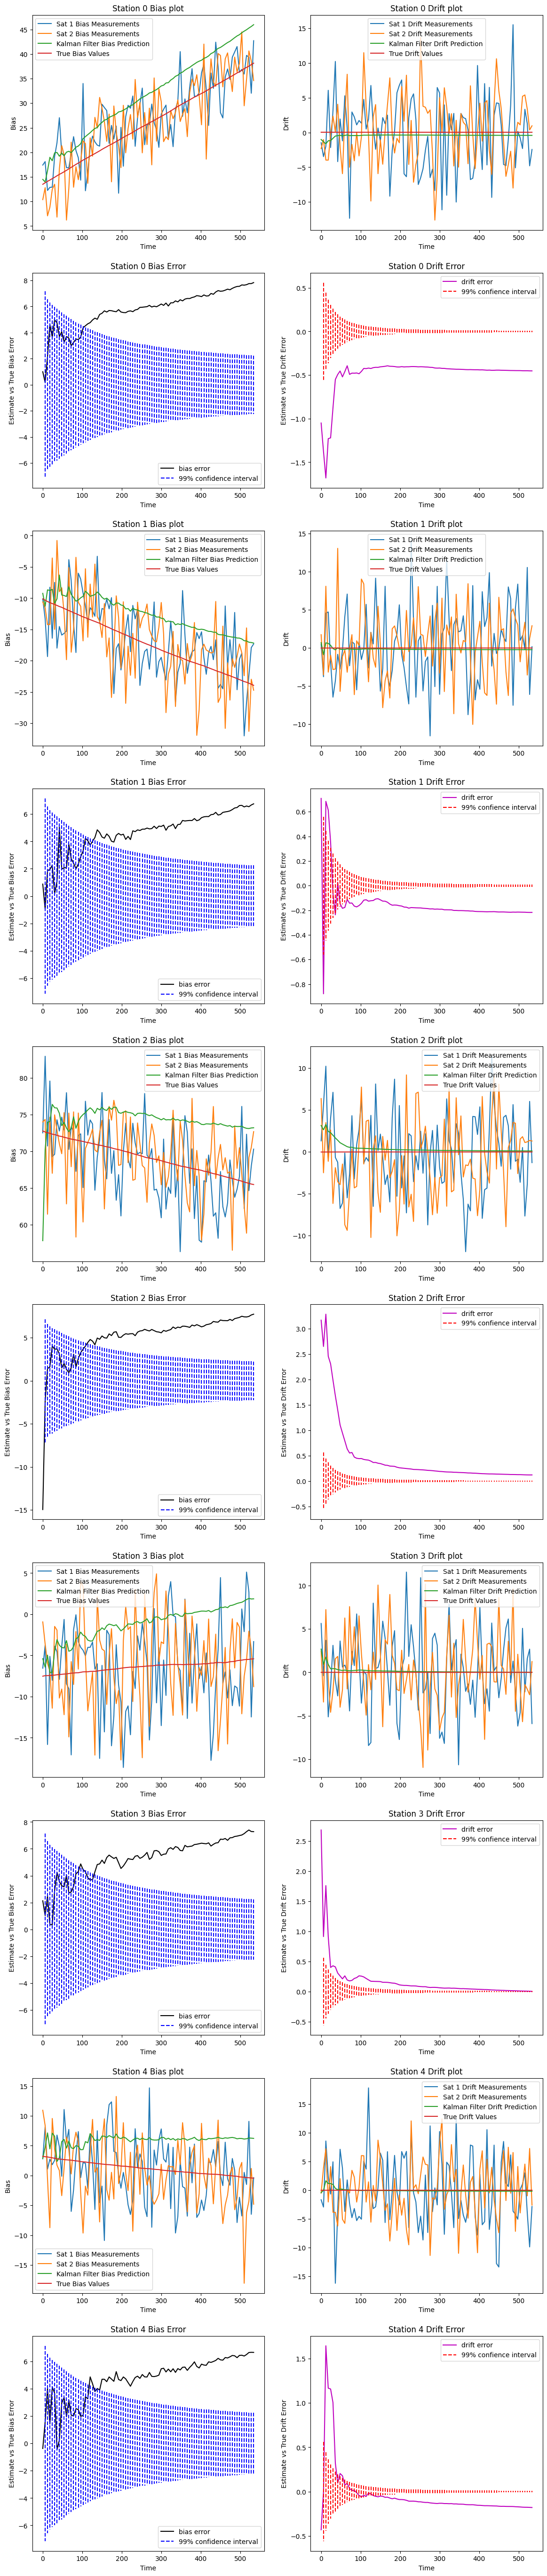

In [10]:
def example():
    C = np.array([[0.2,0.2,0.2,0.2,0.2], [0.5, 0.5, 0, 0,0], [0.5, 0, 0.5, 0,0], [0.5,0,0, 0.5,0],[0.5,0,0,0,0.5]])
    D = np.array([[3,3,3,3,3], [3, 3, 0, 0,0], [3, 0, 3, 0,0], [3,0,0, 3,0],[3,0,0,0,3]])
    n = len(C[0])


    dt = 6
    iterations = 90

    T_g = 0
    true_biases = np.array([[np.random.normal(0,10**(-7)) for _ in range(n)]]).T
    true_drifts = np.array([[np.random.normal(0,10**(-10)) for _ in range(n)]]).T

    def get_station_truth(x,id):
        return np.array([[x[id][0]],[x[n+id][0]]])

    x = c*np.vstack((true_biases,true_drifts))

    # random initial estimates for each node

    x0 = [np.array([[np.random.normal(0,np.sqrt(24))],[np.random.normal(0,np.sqrt(0.2))]]) for i in range(n)]
    # x0 = [np.array([[0],[0]]) for _ in range(5)]

    P = [np.copy(R(1)) for _ in range(n)]

    #Process Noise
    procc_noise = lambda : np.linalg.cholesky(Q) @ np.random.normal(np.array([[0,0]]).T)

    truth = []
    measurements = []
    predictions = []
    errors = np.zeros((iterations,n,2,1))
    P_hist = np.zeros((iterations,n,2,2))
    mse_hist = np.zeros((iterations, 2))

    stations = [Station(i) for i in range(n)]

    filter_initialize(stations,D,x0,P)

    #For the first iteration these are our cross_links


    for i in range(iterations):
        #This gives a pair (bias noise, drift noise) for each station
        noise = np.array([procc_noise().T[0] for _ in range(n)])

        #We reformat the pairs to be added to our truth state vector
        formatted_noise = np.vstack((np.array([noise[:,0]]).T,np.array([noise[:,1]]).T))

        #This is our new truth
        x = np.array([[1,0,0,0,0,dt,0,0,0,0],[0,1,0,0,0,0,dt,0,0,0],[0,0,1,0,0,0,0,dt,0,0],
                    [0,0,0,1,0,0,0,0,dt,0],[0,0,0,0,1,0,0,0,0,dt],[0,0,0,0,0,1,0,0,0,0],
                    [0,0,0,0,0,0,1,0,0,0],[0,0,0,0,0,0,0,1,0,0],[0,0,0,0,0,0,0,0,1,0],
                    [0,0,0,0,0,0,0,0,0,1]])@x + formatted_noise
        truth.append(x)

        T_g += 6
        true_biases = [x[:n][i]/c for i in range(n)]
        true_drifts = [x[n:][i]/c for i in range(n)]



        z = (H_20x10 @ truth[-1]) + measure_noise()
        gps_measurements = [np.array([[z[2*k][0],z[2*k+1][0],z[2*(n+k)][0],z[2*(n+k)+1][0]]]).T for k in range(n)]
        if i == 0:
            measures,time_ests, cov_ests = diffusion_filter_iteration(stations,Q,R,C,gps_measurements, None,None,true_biases,true_drifts,T_g,dt,sigma_j)
        else:
            measures,time_ests,cov_ests = diffusion_filter_iteration(stations,Q,R,C,gps_measurements, time_ests,cov_ests,true_biases,true_drifts,T_g,dt,sigma_j)

        errors[i] = np.array([station.x - get_station_truth(x,station.id) for station in stations])
        measurements.append(measures)
        predictions.append([stn.x for stn in stations])
        P_hist[i] = np.array([station.P for station in stations])

        # compute and store the MSE
        mse = compute_mse(np.array(predictions), np.array(truth), n)
        mse_hist[i] = mse

    #Number of stations whose plots we are looking at
    k = [0,1,2,3,4]

    num_rows = 2*len(k)
    fig,axs = plt.subplots(num_rows,2, figsize=(14, 7*num_rows))
    t_hist = np.arange(0, dt*iterations, dt)
    for inx,i in enumerate(k):
        #20 measurements, 2 for each node
        axs[2*inx][0].plot(t_hist,[x[i][0][0] for x in measurements], label = 'Sat 1 Bias Measurements')
        axs[2*inx][0].plot(t_hist,[x[i][1][0] for x in measurements], label = 'Sat 2 Bias Measurements')
        axs[2*inx][0].plot(t_hist,[x[i][0][0] for x in predictions], label = 'Kalman Filter Bias Prediction')
        axs[2*inx][0].plot(t_hist,[x[i][0] for x in truth], label = 'True Bias Values')
        axs[2*inx][0].set_title("Station "+str(i)+" Bias plot")
        axs[2*inx][0].set_xlabel("Time")
        axs[2*inx][0].set_ylabel("Bias")
        axs[2*inx][0].legend()

        axs[2*inx][1].plot(t_hist,[x[i][2][0] for x in measurements], label = 'Sat 1 Drift Measurements')
        axs[2*inx][1].plot(t_hist,[x[i][3][0] for x in measurements], label = 'Sat 2 Drift Measurements')
        axs[2*inx][1].plot(t_hist,[x[i][1][0] for x in predictions], label = 'Kalman Filter Drift Prediction')
        axs[2*inx][1].plot(t_hist,[x[i+n][0] for x in truth], label = 'True Drift Values')
        axs[2*inx][1].set_title("Station "+str(i)+" Drift plot")
        axs[2*inx][1].set_xlabel("Time")
        axs[2*inx][1].set_ylabel("Drift")
        axs[2*inx][1].legend()



        axs[2*inx+1][0].plot(t_hist, errors[:, i,0,0], 'k', label = "bias error")
        axs[2*inx+1][0].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([3*np.sqrt(P_hist[1, i,0,0]), -3*np.sqrt(P_hist[1, i, 0,0])]), 'b--', label = "99% confidence interval")
        axs[2*inx+1][0].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([3*np.sqrt(P_hist[2:, i,0,0]), -3*np.sqrt(P_hist[2:, i, 0,0])]), 'b--')
        axs[2*inx+1][1].plot(t_hist, errors[:, i,1,0], 'm', label = "drift error")
        axs[2*inx+1][1].plot(np.vstack([t_hist[1], t_hist[1]]), np.vstack([3*np.sqrt(P_hist[1, i,1,1]), -3*np.sqrt(P_hist[1, i, 1,1])]), 'r--', label = "99% confience interval")
        axs[2*inx+1][1].plot(np.vstack([t_hist[2:], t_hist[2:]]), np.vstack([3*np.sqrt(P_hist[2:, i,1,1]), -3*np.sqrt(P_hist[2:, i, 1,1])]), 'r--')
        axs[2*inx+1][0].legend()
        axs[2*inx+1][0].set_title("Station "+str(i)+" Bias Error")
        axs[2*inx+1][0].set_xlabel("Time")
        axs[2*inx+1][0].set_ylabel("Estimate vs True Bias Error")
        axs[2*inx+1][1].legend()
        axs[2*inx+1][1].set_title("Station "+str(i)+" Drift Error")
        axs[2*inx+1][1].set_xlabel("Time")
        axs[2*inx+1][1].set_ylabel("Estimate vs True Drift Error")

    plt.show()

if __name__ == '__main__':
    example()
